# Paquetes

In [1]:
import read_data as imp
import numpy as np
import pandas as pd
import pyfolio as pf
import matplotlib.pyplot as plt
import Alphas101 as Alphas

import matplotlib as plt
from math import sqrt
from yellowbrick.cluster import KElbowVisualizer
from statistics import stdev
from pylab import plot,show
from numpy import vstack,array
from numpy.random import rand
from scipy.cluster.vq import kmeans,vq
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA 

'''Data Prep and Model Evaluation'''
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import log_loss, accuracy_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, mean_squared_error
from keras.utils import to_categorical
from sklearn.metrics import adjusted_rand_score
import random

'''Algos'''
import tslearn
from tslearn.utils import to_time_series_dataset
from tslearn.clustering import KShape, TimeSeriesScalerMeanVariance
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import AgglomerativeClustering
from pyclustering.cluster.kmedoids import kmedoids
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import dendrogram, linkage
from pyclustering.cluster.clarans import clarans;
from pyclustering.utils import timedcall;
from sklearn import datasets
import operator
import calendar
import itertools as it

import time

import warnings
warnings.filterwarnings("ignore")

C:\Anaconda3\lib\site-packages\pyfolio\pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +
WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Using TensorFlow backend.


# Funciones Auxiliares

In [2]:
def compute_distances(points):
    n = points.shape[0]
    distances = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            distances[i,j] = np.linalg.norm(points[i,:] - points[j,:])
    return distances

def cluster(distances, k=3):

    m = distances.shape[0] # number of points

    # Pick k random medoids.
    curr_medoids = np.array([-1]*k)
    while not len(np.unique(curr_medoids)) == k:
        curr_medoids = np.array([random.randint(0, m - 1) for _ in range(k)])
    old_medoids = np.array([-1]*k) # Doesn't matter what we initialize these to.
    new_medoids = np.array([-1]*k)

    # Until the medoids stop updating, do the following:
    while not ((old_medoids == curr_medoids).all()):
        # Assign each point to cluster with closest medoid.
        clusters = assign_points_to_clusters(curr_medoids, distances)

        # Update cluster medoids to be lowest cost point.
        for curr_medoid in curr_medoids:
            cluster = np.where(clusters == curr_medoid)[0]
            new_medoids[curr_medoids == curr_medoid] = compute_new_medoid(cluster, distances)

        old_medoids[:] = curr_medoids[:]
        curr_medoids[:] = new_medoids[:]

    return clusters, curr_medoids

def assign_points_to_clusters(medoids, distances):
    distances_to_medoids = distances[:,medoids]
    clusters = medoids[np.argmin(distances_to_medoids, axis=1)]
    assert (clusters[medoids] == medoids).all()
    return clusters

def compute_new_medoid(cluster, distances):
    mask = np.ones(distances.shape)
    mask[np.ix_(cluster,cluster)] = 0.
    cluster_distances = np.ma.masked_array(data=distances, mask=mask, fill_value=10e9)
    costs = cluster_distances.sum(axis=1)
    return costs.argmin(axis=0, fill_value=10e9)

### Kshape

In [3]:
def strategy_kshape(df, K = 4):
    X = TimeSeriesScalerMeanVariance(mu=0., std=1.).fit_transform(df.T.values)[:,:,0]
    ks = KShape(n_clusters=K, max_iter=100, n_init=100, verbose=0).fit(X)

    index = list(range(len(df.columns)))
    columns = ['strategies', 'clusters', 'selection']
    results = pd.DataFrame(index=index, columns=columns)
    results['clusters'] = ks.labels_
    results['strategies'] = df.columns

    sharpeclusters = []
    for i in range(results['clusters'].nunique()):
        l = results.loc[results['clusters'] == i].index.values.astype(int).tolist()
        dfexp = df.iloc[:, l].sum(axis=1, skipna=True)/len(l)
        sharpeclusters.append(pf.timeseries.perf_stats(dfexp)['Sharpe ratio'])
    sharpeclusters = np.asanyarray(sharpeclusters)

    selection = sharpeclusters.argmax()
    cond = results['clusters'] == selection

    results['selection'] = np.where(cond, 1, 0)

    return results['strategies'][results['selection'] == 1].values.tolist()

### Kmeans

In [4]:
def strategy_kmeans(df, K =3):

    data = pd.DataFrame(columns= df.columns)
    for col in df.columns:
        data[col] = pf.timeseries.perf_stats(df[col])
    data = data.T.values

    n_samples = 1500
    random_state = 170

    kmeans1 = KMeans(n_clusters=K, random_state=random_state)
    kmeans1.fit(data)
    
    results=pd.DataFrame({'Returns': data[:, 0], 
                       'Volatility': data[:, 2],
                       'ClusterkMeans':kmeans1.labels_,
                       'strategies': df.columns,
                      })
    
    sharpeclusters =[] 
    for i in range(results['ClusterkMeans'].nunique()):
        l = results.loc[results['ClusterkMeans'] == i].index.values.astype(int).tolist()
        dfexp=df.iloc[:,l].sum(axis = 1, skipna = True)/len(l)
        sharpeclusters.append(pf.timeseries.perf_stats(dfexp)['Sharpe ratio'])
    sharpeclusters = np.asanyarray(sharpeclusters)

    selection = sharpeclusters.argmax()
    cond = results['ClusterkMeans'] == selection
    results['selection'] = np.where(cond, 1, 0)
        
    return results['strategies'][results['selection'] == 1].values.tolist()

### TSKmeans - Euclidean

In [5]:
def strategy_tskmeans_euclidean (df, K =4, metric = "euclidean"):
   
    X = TimeSeriesScalerMeanVariance(mu=0., std=1.).fit_transform(df.T.values)
    km = TimeSeriesKMeans(n_clusters=4, max_iter=200, n_init=200,tol = 1e-8,
                          metric= metric, verbose=0, random_state=2019).fit(X)

    index = list(range(len(df.columns)))
    columns = ['strategies', 'clusters', 'selection']

    results = pd.DataFrame(index=index, columns=columns)

    results['clusters'] = km.labels_
    results['strategies'] = df.columns

    sharpeclusters = []
    for i in range(results['clusters'].nunique()):
        l = results.loc[results['clusters'] == i].index.values.astype(int).tolist()
        dfexp = df.iloc[:, l].sum(axis=1, skipna=True)/len(l)
        sharpeclusters.append(pf.timeseries.perf_stats(dfexp)['Sharpe ratio'])
    sharpeclusters = np.asanyarray(sharpeclusters)

    selection = sharpeclusters.argmax()
    cond = results['clusters'] == selection

    results['selection'] = np.where(cond, 1, 0)

    return results['strategies'][results['selection'] == 1].values.tolist()

### Clarans

In [6]:
def strategy_clarans(df,k=3,v=4):
    df2 = df.transpose()
    data = np.array(df2)
    data = data.tolist()

    clarans_instance = clarans(data, k, 6, v);
    #calls the clarans method 'process' to implement the algortihm
    (ticks, result) = timedcall(clarans_instance.process);

    #returns the clusters 
    clusters = clarans_instance.get_clusters();

    #returns the mediods 
    medoids = clarans_instance.get_medoids();

    dic = {}
    for var in range(len(clusters)):
        for var2 in clusters[var]:
            dic[var2] = var


    resultado = sorted(dic.items(), key=operator.itemgetter(0))

    dic = {}
    for var in resultado:
        dic[df2.index[var[0]]] = var[1]

    clf = pd.DataFrame.from_dict(dic,orient='index')
    clf = clf.reset_index()
    results = clf.rename(columns={'index':'strategies',0:'clusters'})

    sharpeclusters =[] 
    for i in range(results['clusters'].nunique()):

        l = results.loc[results['clusters'] == i].index.values.astype(int).tolist()
        dfexp=df.iloc[: , l].sum(axis = 1, skipna = True)/len(l)
        
        sharpeclusters.append(pf.timeseries.perf_stats(dfexp)['Sharpe ratio'])
    sharpeclusters = np.asanyarray(sharpeclusters)

    selection = sharpeclusters.argmax()
    cond = results['clusters'] == selection

    results['selection'] = np.where(cond, 1, 0)

    return results['strategies'][results['selection'] == 1].values.tolist()

### Kmedoids

In [7]:
def strategy_kmedoids(df, K = 3):
    
    data = pd.DataFrame(columns= df.columns)
    for col in df.columns:
        data[col] = pf.timeseries.perf_stats(df[col])
    data = data.T.values

    distances = compute_distances(data)    

    _clusters, medoids = cluster(distances, K)

    results=pd.DataFrame({'Returns': data[:, 0], 
                   'Volatility': data[:, 1],
                   'ClusterkMedoids':_clusters,
                   'strategies': df.columns,
                  })

    medoidsclusters =[] 

    for i in results.ClusterkMedoids.unique():
        l = results.loc[results['ClusterkMedoids'] == i].index.values.astype(int).tolist()
        dfexp=df.iloc[: , l].sum(axis = 1, skipna = True)/len(l)
        medoidsclusters.append(pf.timeseries.perf_stats(dfexp)['Sharpe ratio'])
    medoidsclusters = np.asanyarray(medoidsclusters)    

    selection = medoidsclusters.argmax()

    cond = results['ClusterkMedoids'] == results.ClusterkMedoids.unique()[selection]

    results['selection'] = np.where(cond, 1, 0)    

    return results['strategies'][results['selection'] == 1].values.tolist()

# Backtesting

In [8]:
Estrategias = pd.read_csv('Rentabilidad de estrategias Sectoriales base 100.csv')
Estrategias.set_index('Date', inplace = True)
Estrategias.index = pd.to_datetime(Estrategias.index)

In [9]:
Initial_Date = pd.to_datetime('2014-01-01')

Rebalancing_dates = []
curr_month = Initial_Date.month

the_start = np.where(Initial_Date == Estrategias.index)[0].tolist()[0]

for i in range((the_start+1), len(Estrategias.index)):
    if Estrategias.index[i].month != curr_month:
        Rebalancing_dates.append(Estrategias.index[i-1])
        curr_month = Estrategias.index[i].month

## Cálculo de la rentabilidad de los retornos

In [10]:
Clustering_Returns = pd.DataFrame(index = Estrategias.index[Estrategias.index >= Initial_Date],
                                  columns = ['Kshape', 'Kmeans', 'TSKM-E', 'Clarans', 'Kmedoids'])

Kshape = []
Kmeans = []
TSKME = []
Clarans = []
Kmedoids = []

Memory_time_window = 126

for i in Estrategias.index[Estrategias.index >= Initial_Date]:
            
    if i in Rebalancing_dates:
        
        end = np.where(i == Estrategias.index)[0].tolist()[0]
        ini = end - Memory_time_window
        
        # update Baskets
        
        Kshape = strategy_kshape(Estrategias.iloc[ini:end,:])
        Kmeans = strategy_kmeans(Estrategias.iloc[ini:end,:])
        TSKME = strategy_tskmeans_euclidean(Estrategias.iloc[ini:end,:])
        Clarans = strategy_clarans(Estrategias.iloc[ini:end,:])
        Kmedoids = strategy_kmedoids(Estrategias.iloc[ini:end,:])
        
        # Return calculus
        
        Clustering_Returns.loc[i,'Kshape'] = Estrategias.loc[i,Kshape].sum()/len(Kshape)
        Clustering_Returns.loc[i,'Kmeans'] = Estrategias.loc[i,Kmeans].sum()/len(Kmeans)
        Clustering_Returns.loc[i,'TSKM-E'] = Estrategias.loc[i,TSKME].sum()/len(TSKME)
        Clustering_Returns.loc[i,'Clarans'] = Estrategias.loc[i,Clarans].sum()/len(Clarans)
        Clustering_Returns.loc[i,'Kmedoids'] = Estrategias.loc[i,Kmedoids].sum()/len(Kmedoids)
        
    else:
        
        Clustering_Returns.loc[i,'Kshape'] = Estrategias.loc[i,Kshape].sum()/len(Kshape)
        Clustering_Returns.loc[i,'Kmeans'] = Estrategias.loc[i,Kmeans].sum()/len(Kmeans)
        Clustering_Returns.loc[i,'TSKM-E'] = Estrategias.loc[i,TSKME].sum()/len(TSKME)
        Clustering_Returns.loc[i,'Clarans'] = Estrategias.loc[i,Clarans].sum()/len(Clarans)
        Clustering_Returns.loc[i,'Kmedoids'] = Estrategias.loc[i,Kmedoids].sum()/len(Kmedoids)

In [11]:
Clustering_Returns_TS = 100 * (Clustering_Returns+1).cumprod()
Clustering_Returns.to_csv('Cluster Rent Sectoriales Base 100.csv')

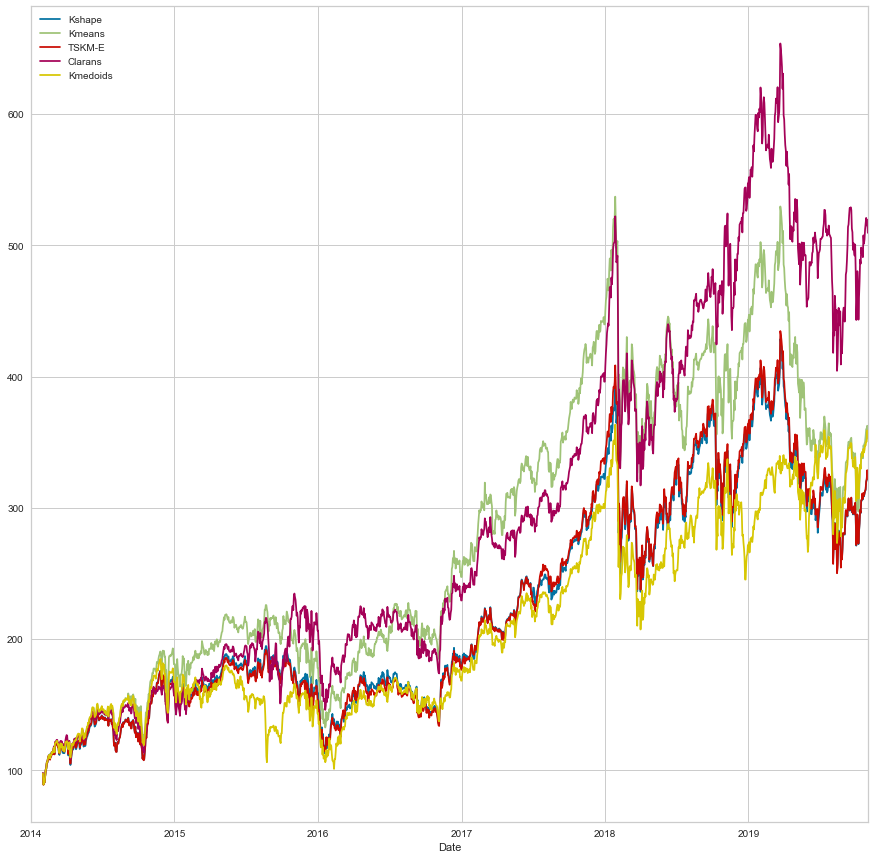

In [12]:
Clustering_Returns_TS.plot(figsize=(15,15))